In [ ]:
!uv pip install openai-clip --system -q

In [1]:
!uv pip install git+https://github.com/facebookresearch/segment-anything.git

Using Python 3.10.14 environment at /opt/homebrew/Caskroom/miniconda/base/envs/temp
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookresearch/segment-anything.git (HEAD)
Updating https://github.com/facebookrese

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
import cv2
import clip  # CLIP model


In [ ]:
GRID_SIZE = 8

from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)
from torchvision.ops.boxes import batched_nms, box_area

# Load CLIP model and preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

def process_small_region(rles):
    # Function as before to remove small regions
    new_masks = []
    scores = []
    min_area = 100
    nms_thresh = 0.7
    for rle in rles:
        mask = rle_to_mask(rle[0])
        mask, changed = remove_small_regions(mask, min_area, mode="holes")
        unchanged = not changed
        mask, changed = remove_small_regions(mask, min_area, mode="islands")
        unchanged = unchanged and not changed

        new_masks.append(torch.as_tensor(mask).unsqueeze(0))
        scores.append(float(unchanged))

    # Recalculate boxes and remove duplicates using NMS
    masks = torch.cat(new_masks, dim=0)
    boxes = batched_mask_to_box(masks)
    keep_by_nms = batched_nms(
        boxes.float(),
        torch.as_tensor(scores),
        torch.zeros_like(boxes[:, 0]),
        iou_threshold=nms_thresh,
    )

    # Recalculate RLEs for changed masks
    for i_mask in keep_by_nms:
        if scores[i_mask] == 0.0:
            mask_torch = masks[i_mask].unsqueeze(0)
            rles[i_mask] = mask_to_rle_pytorch(mask_torch)
    masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
    return masks

def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(img_path, model):
    model = model.cpu()
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
        predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
              img_tensor.cpu(),
              points.reshape(1, num_pts, 1, 2).cpu(),
              point_labels.reshape(1, num_pts, 1).cpu(),
              model.cpu(),
          )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)

    # Use CLIP to generate embeddings for each mask
    mask_embeddings = []
    for mask in predicted_masks:
        mask = Image.fromarray(mask)
        mask = preprocess(mask).unsqueeze(0).to(device)
        with torch.no_grad():
            mask_embedding = clip_model.encode_image(mask)
        mask_embeddings.append(mask_embedding)

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 48.5MiB/s]


Cloning into 'EfficientSAM'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 424 (delta 76), reused 52 (delta 52), pack-reused 339 (from 1)
Receiving objects: 100% (424/424), 262.14 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Updating files: 100% (38/38), done.


/content/EfficientSAM/efficient_sam/efficient_sam.py:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location="cpu")


AttributeError: 'numpy.ndarray' object has no attribute 'float'

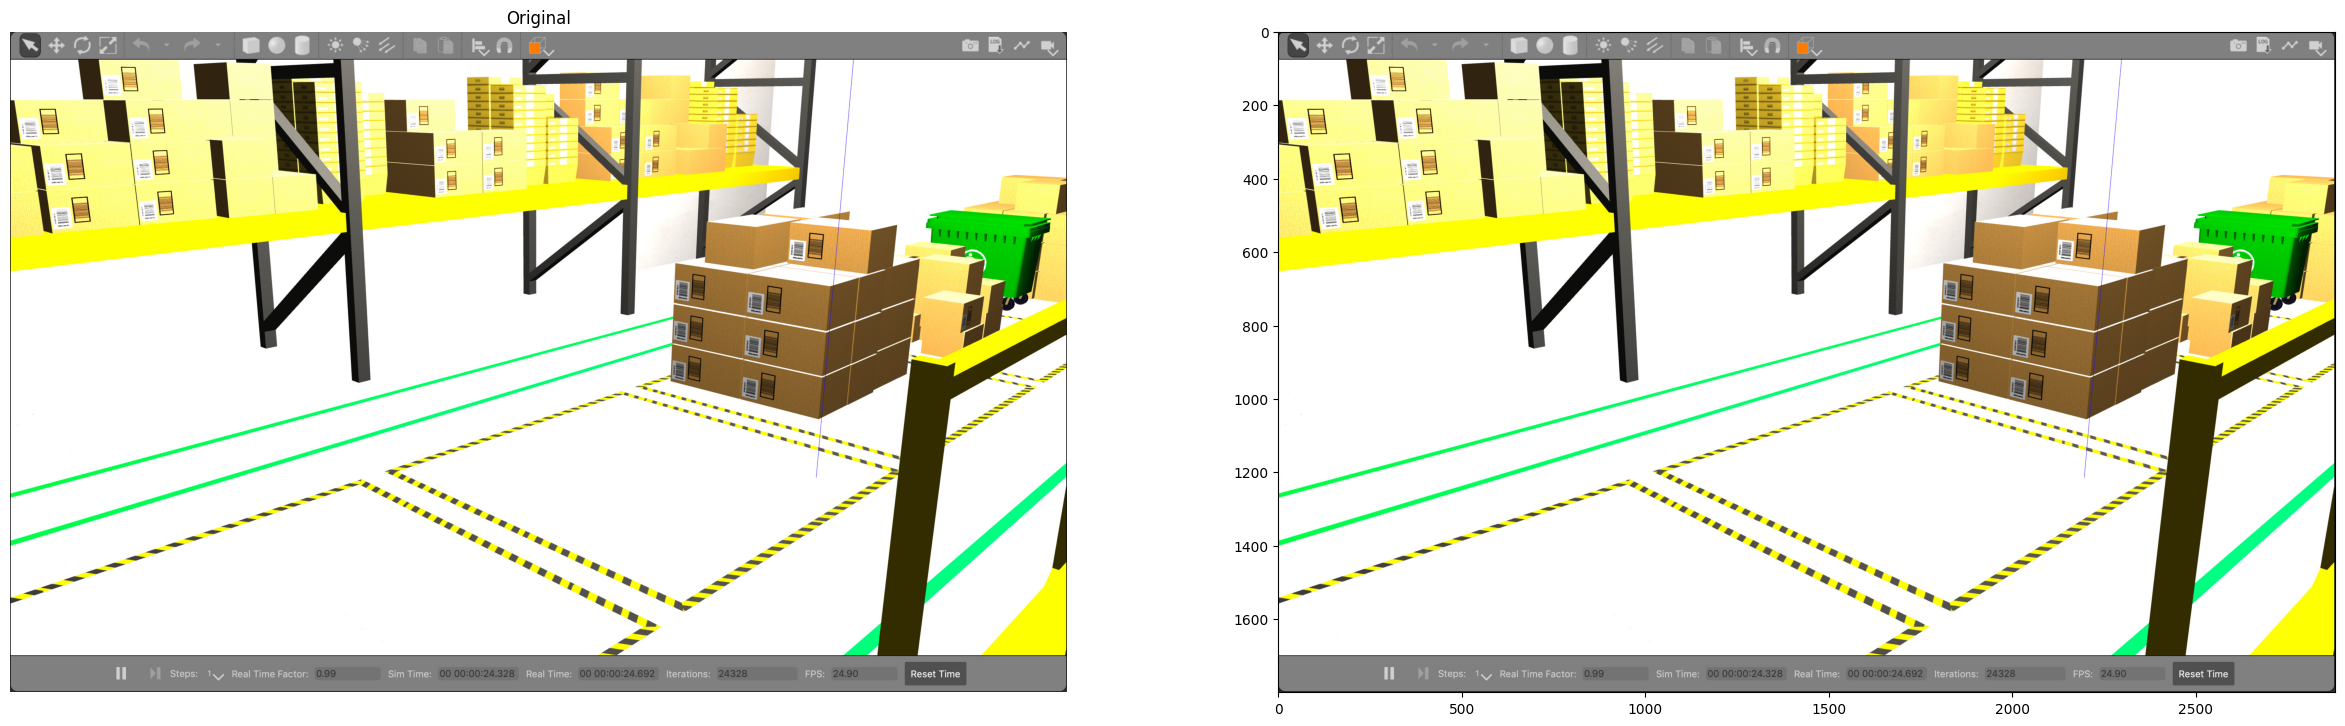

In [7]:

# Run EfficientSAM segmentation and CLIP embedding extraction
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import zipfile

with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

import urllib
url = "https://global.discourse-cdn.com/flex020/uploads/ros/original/2X/1/165e9345cd27913589c9a72d65be09a62985ae0b.jpeg"

image = urllib.request.urlopen(url).read()
image = Image.open(io.BytesIO(image))
image_path = "image.jpg"
image.save(image_path)

fig, ax = plt.subplots(1, 2, figsize=(30, 30))

ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')

ax[1].imshow(image)
mask_efficient_sam_vits, clip_embeddings = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM")
ax[1].axis('off')

plt.show()

# Displaying the embeddings for each segment
for idx, emb in enumerate(clip_embeddings):
    print(f"Embedding for segment {idx}: {emb.shape}")
